In [16]:
%config InlineBackend.rc = {"figure.dpi": 72, 'figure.figsize': (6.0, 4.0)}
%matplotlib inline

import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read

abtem.config.set({"local_diagnostics.progress_bar": False});

(walkthrough:partial_coherence)=
# Partial coherence

In our [walkthrough on the contrast transfer function](walkthrough:contrast_transfer_function), we described how partial coherence may be approximated by multiplication with an envelope function. This approach is not always appropriate for simulating experiments with plane wave illumination and it is never appropriate for simulating experiments with a convergent beam.

## Partial temporal coherence with plane waves

Partial temporal coherence is generally more important than partial temporal coherence. In this section, we compare the quasicoherent approximation to the accurate inc

We simulate an exit wave at $80 \ \mathrm{keV}$ using a sample of MoS<sub/>2.

In [17]:
exit_wave = abtem.PlaneWave(energy=80e3, sampling=0.05).multislice(
    ase.build.mx2(vacuum=2)
)

Next we apply a contrast transfer function using the Scherzer defocus with a spherical aberration of $-20 \ \mu m$ and a focal spread of $52.5 \ \mathrm{Å}$. See the [walkthrough on the CTF](walkthrough:contrast_transfer_function) for details.

In [7]:
Cs = -20e-6 * 1e10
focal_spread = 52.50

# Create coherent CTF
ctf_coherent = abtem.CTF(Cs=Cs, energy=80e3)
ctf_coherent.defocus = ctf_coherent.scherzer_defocus
ctf_coherent.semiangle_cutoff = ctf_coherent.crossover_angle

# Create CTF with temporal coherence envelope
ctf_quasi_coherent = ctf_coherent.copy()
ctf_quasi_coherent.focal_spread = focal_spread

# Run multislice and get intensity
image_coherent = exit_wave.apply_ctf(ctf_coherent).intensity()
image_quasi_coherent = exit_wave.apply_ctf(ctf_quasi_coherent).intensity()

In the fully incoherent model, we integrate over images at different defocii 

$$
    I_{incoherent} = \int_{-\infty}^{\infty} p(\Delta f) I(\Delta f) \ \mathrm{d} \Delta f \quad ,
$$

the image intensity given an exit wave function, $\psi_{exit}$, and the phase aberrations, $\chi(\Delta f)$, with the defocus, $\Delta f$, may be written

$$
    I(\Delta f) = \left\| \mathcal{F^{-1}}\left[ \hat{\psi}_{exit} \exp(-i \chi(\Delta f) \right] \right\|^2 \quad ,
$$

where for clarity we have omitted the coordinates. 

The weighting function is assumed to be Gaussian

$$
    p(\Delta f) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{(\Delta f_{center} - \Delta f) ^ 2}{2\sigma ^ 2}\right)
$$

where $\sigma$ is the focal spread.

We approximate Eq. as a Riemann sum

$$
    I_{incoherent} = \sum_{\Delta f_n} p(\Delta f_n) I(\Delta f_n)
$$

where we need to choose a set of $N$ samples 

$$
    \Delta f_n = \Delta f_{center} - \Delta f_{truncation} + \frac{2 n \Delta f_{truncation}}{N}
$$

where $n=0,1,\ldots,N$ and the truncation of the sum, $\Delta f_{truncation}$, have to be chosen such that $p(\Delta f)$ is small.

In [9]:
ctf_incoherent = ctf_coherent.copy()

defocus = abtem.distributions.gaussian(
    center=ctf_incoherent.scherzer_defocus,
    standard_deviation=focal_spread,
    num_samples=7,
    sampling_limit=1.5,
)

ctf_incoherent.defocus = defocus

In [10]:
images_incoherent = exit_wave.apply_ctf(ctf_incoherent).intensity()

images_incoherent

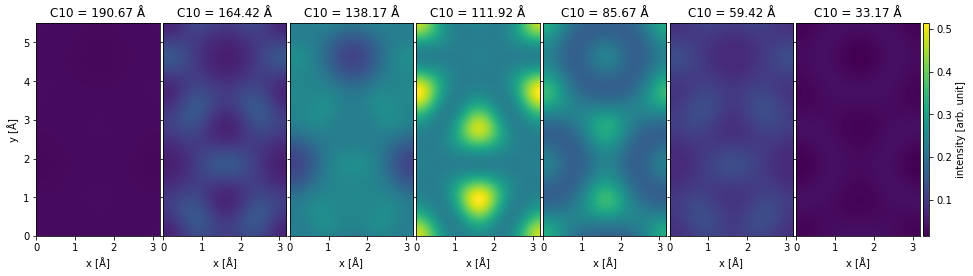

In [12]:
images_incoherent.show(
    explode=True,
    figsize=(16, 5),
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
);

In [36]:
image_incoherent = images_incoherent.sum(0)

stack = abtem.stack(
    [image_coherent, image_quasi_coherent, image_incoherent],
    ("coherent", "quasi-coherent", "incoherent"),
)

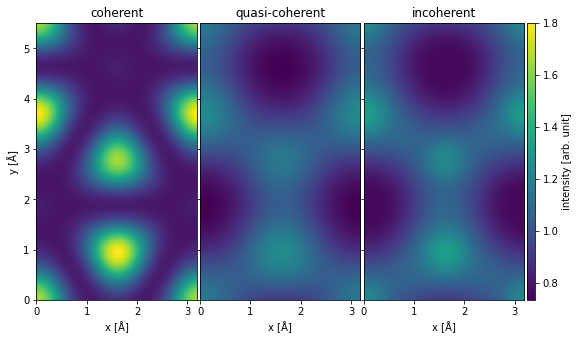

In [37]:
stack.show(
    common_color_scale=True,
    explode=True,
    cbar=True,
    figsize=(18, 5),
    image_grid_kwargs={"axes_pad": 0.05},
);

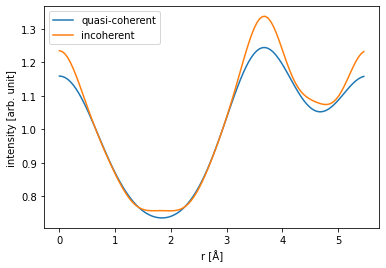

In [38]:
stack[1:].interpolate_line(start=(0, 0), end=(0, stack.extent[1])).show();

## Partial coherence with probes

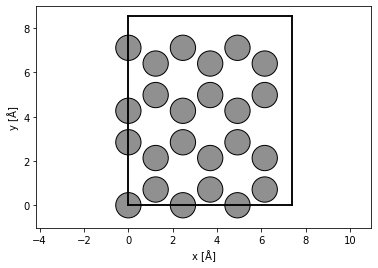

In [106]:
atoms = ase.build.graphene(vacuum=2)

atoms = abtem.orthogonalize_cell(atoms) * (3, 2, 1)

abtem.show_atoms(atoms);

In [103]:
source_size = 0.318
Cc = 1.3 * 1e-3 * 1e10
dE = 0.148
focal_spread = Cc * dE / probe.energy

defocus_distribution = abtem.distributions.gaussian(
    center=0.0,
    standard_deviation=focal_spread,
    num_samples=11,
    sampling_limit=2,
    ensemble_mean=False,
)

In [104]:
probe_coherent = abtem.Probe(energy=60e3, semiangle_cutoff=30, sampling=0.05)
probe_temporal = abtem.Probe(
    energy=60e3, semiangle_cutoff=30, sampling=0.05, defocus=defocus_distribution
)

detector = abtem.PixelatedDetector()

scan = abtem.GridScan.from_fractional_coordinates(
    atoms, (0, 0), (1 / 3, 1 / 2), sampling=0.1
)

measurement_coherent = probe_coherent.scan(
    atoms, detectors=detector, scan=scan
).compute()

measurement_temporal = probe_temporal.scan(
    atoms, detectors=detector, scan=scan
).compute()

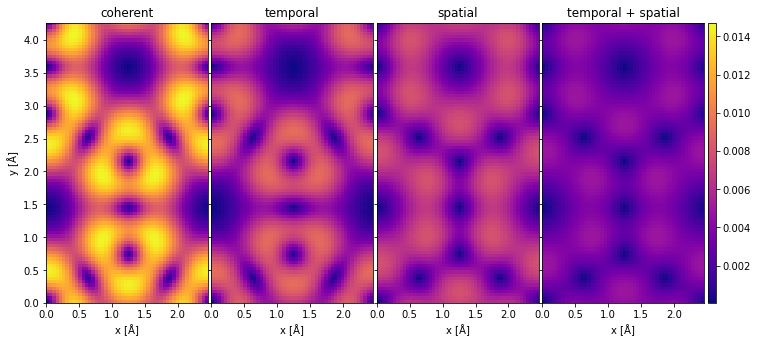

In [105]:
measurement_spatial = measurement_coherent.gaussian_source_size(0.3)
measurement_spatial_and_temporal = measurement_temporal.gaussian_source_size(0.3)

measurements = abtem.stack(
    (
        measurement_coherent,
        measurement_temporal,
        measurement_spatial,
        measurement_spatial_and_temporal,
    ),
    ("coherent", "temporal", "spatial", "temporal + spatial"),
)

measurements.center_of_mass().interpolate(.05).abs().show(
    figsize=(12,6),
    explode=True,
    common_color_scale=True,
    image_grid_kwargs={"axes_pad": 0.05},
    cbar=True,
    cmap="plasma"
);

In [ ]:
measurements.center_of_mass().interpolate_line(start=(0,0), end=(0,))

In [ ]:
measurements